# House Price Prediction in Pittsburgh

### Motivation and Objectives

A home is often the largest and most expensive purchase a person makes in his or her lifetime. The house prices of a city can ususally reflects the economic condition to some extend. Moreover, house prices trends are always a concern of as an asset investment for buyers. Therefore, as data scientist, creating a decent house price prediction model can help people to make decision in making house investment. 

Unlike other house price prediction model, our model collects data from multiple resources, including trulia.com, which is a home and neighborhood website that offers buyers and renters detailed information related to the house on sell. In addition, We also collect data from YELP about the restaurant nearby a given house as well as the walkscore date of walkability, availability of transit and bike are also collected from the walk score API. 



### Table of Content:

1. [Data Collection](#Data-Collection)
2. [Dataset Description](#Dataset-Description)
3. [Data Cleaning](#Data-Cleaning)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Data Preprocessing](#Data-Preprocessing)
6. [Feature Exploration, Engineering and Cleaning]
7. [Predictive Model]
8. [Conclusion]
9. [Limitation and Future Work]
10. [Reference]

### Import Libraries

In [96]:

import pandas as pd
import io, time, json
import requests
from pathlib import Path
from bs4 import BeautifulSoup
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew
from scipy import stats
import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')
from scipy.special import boxcox1p


## Data Collection

The dataset for this project is mainly collected from three sources, Trulia.com, Yelp API and WalkScore.com. In order to get recent transaction of property sold in Pittsburh, a list of properties sold within 9 month is scraped from trulia websearch page. We believe that the property value is closely related to the the walkability of the neighborhoods. That is, a walkable neighborhoods with high accessibility to quality public transit, civic and community facilities and services tend to raise property value. With this purpose, we collect relavant neiborhood information from WalkScore and Yelp API. The data collection pipeline is shown in blow figure.




<img src="./img/data_collection2.jpg" alt="Drawing" style="width: 600px;"/>

When we scrape data from trulia and walkscore webpages, we used `agent` and `time.sleep()` to pretend human users and avoid being denied from accessing. It takes too long to run the whole data block related to data collection. To better illustrate the process, we will use an example from the dataset to walk you through the process. The code we used for scraping the data will also be provided at each step.

#### Step 1 - Scrape property sold transaction list from Trulia
The first step is to scrape a list of houses in Pittsburgh that were sold in the last 9 months. Since we used `time.sleep()` to pretend we are human users, it takes too long to run the whole block of code we used in this step. Please check [`data_collection_trulia_list.py`](./code/data_collection_trulia_list.py) for detailed code of this step. We restrict the property sold transaction within the last 9 months. Below is an example, it is one of the data entries we scraped from Trulia. We will use the example in the following steps. 

| street_address | postal_code | latitude | longitude | link | page | num | address_locality | address_region | scrape_generated | link_generated | is_same | property |
| --- |:---:|:--- |: --- |:---:|:--- |: --- |:---:|:--- |: --- |:---:|:--- |: --- |
|701 Amberson Ave |	15232 |	40.450714 |	-79.94018 |	https://www.trulia.com/p/pa/pittsburgh/701-amberson-ave-pittsburgh-pa-15232--2014230510 | 160 | 15 | Pittsburgh | PA | 701 amberson ave pittsburgh pa 15232 | 701 amberson ave pittsburgh pa 15232 | 1 | 0 |


Some of the houses have different format than others in the html content, which makes the output csv not we expected. We select these entries, check the information and input the correct information manually. The output is stored as a csv file. Please refer to [`scrape_trulia_list.csv`](./scrape_data/scrape_trulia_list.csv) in the "scrape" folder for detailed information.

#### Step 2 - Scrape data from Yelp
Once we get latitude and longitude of the house from step 1, we can collect nearby restaurant, art and entertainment, as well as grocery information for each property from Yelp through making authenticated HTTP request to the Yelp API business search endpoint. The query passed to API request include `latitude` and `longitude` of the property, search `radius` and the `category` for business search.  
The data we collected from Yelp are
 * number of restaurant nearby
 * average rating of restaurant nearby
 * average price level of restaurant nearby
 * number of art and entertainment services nearby
 * number of grocery store nearby

Some example code to get data from Yelp API is shown in below block.  Please check [`scrape_yelp&walkscore.py`](./code/dscrape_yelp&walkscore.py) for detailed code of this step. 

In [55]:
# source code from course homework
# Args: url (string):
# Returns: status_code (integer), raw_html (string)
def retrieve_html(url):
   
    response = requests.get(url)
    status = response.status_code
    content = response.text
    
    return (status, content)

def read_api_key(filepath=r"./scrape_data/api_key_clear.txt"):
    return Path(filepath).read_text().strip()

# Make an authenticated request to the Yelp API, modified from 
# Args:  query (tuple): (latitude, longitude, radius, category)
# returns: total (integer): total number of businesses on Yelp corresponding to the query 
#          businesses (list): list of dicts representing each business

def yelp_search(api_key, query):
        
    header =  {'Authorization': 'Bearer '+ api_key}
    url = "https://api.yelp.com/v3/businesses/search"
    searchKey = dict()
    
    
    lat, long, radius, cat = query
    
    searchKey["latitude"] = lat
    searchKey["longitude"] = long
    searchKey["radius"] = radius
    searchKey["categories"] = cat
    
    searchKey["sort_by"] = "distance"
    searchKey["location"] = "Pittsburgh"
    
    response = requests.get(url, params=searchKey, headers=header)
     
    
    business = []
    
    responseDict = json.loads(response.text)
    
    if "businesses" in responseDict:
        business = responseDict["businesses"]
        
    total = responseDict["total"]
    
    return total, business

# Get average rating and price level of business list
# Args: total: total (integer): total number of businesses
#       businesses (list): list of dicts representing each business
# Returns: average_rating(float), average_price(float)
def get_average(total, business):
    
    ratings = 0
    prices = 0
    rating_count = 0
    price_count = 0
    res_rating = 0
    res_price = 0
    
    for res in business:

        if "rating" in res:
            rating = res["rating"]
            ratings += rating
            rating_count += 1
        
        
        if "price" in res:
            price = res["price"]
            prices += len(price)
            price_count += 1
            
    if rating_count != 0:
        res_rating = ratings / rating_count
        
    if price_count != 0:
        res_price = prices / price_count
    
    if total == 0:
        return 0, 0
        
    return res_rating, res_price

In below block, we use an example to illustrate the content we scrape from yelp.

In [56]:
df = pd.read_csv(r"./scrape_data/scrape_trulia_list.csv")
item = df[df["street_address"] == "701 Amberson Ave"]
lat, long, url = item["latitude"], item["longitude"], item["link"]
query_restaurant = (lat, long, 1000, "restaurants")
query_art = (lat, long, 1500, "arts")
query_grocery = (lat, long, 1500, "grocery")
total_restaurant, business_restaurant = yelp_search(read_api_key(), query_restaurant)
average_rating, average_price = get_average(total_restaurant, business_restaurant)
total_art, business_art = yelp_search(read_api_key(), query_art)
total_grocery, business_grocery = yelp_search(read_api_key(), query_grocery)
print("number of restaurant nearby: %d " %total_restaurant)
print("average rating of restaurant nearby: %0.1f " %average_rating)
print("average price level of restaurant nearby: %0.1f " %average_price)
print("number of art and entertainment nearby: %d " %total_art)
print("number of grocery nearby: %d " %total_grocery)

number of restaurant nearby: 92 
average rating of restaurant nearby: 3.6 
average price level of restaurant nearby: 1.5 
number of art and entertainment nearby: 46 
number of grocery nearby: 13 


#### Step 3 - Scrape scores from WalkScore
The next step is to retrive walkability, transit accessibility and bike accessibility of corresponding location from WalkScore webpage. We then generate corresponding WalkScore url for each property using property street address and scrape scores from webpage badges. The code block below shows some base function we use to scrape score,  Please check [`scrape_yelp&walkscore.py`](./code/dscrape_yelp&walkscore.py) for detailed code of this step. 

In [57]:
# Generate link to corresponding walkscore webpage according to a house's trulia link
# Args: link(string): trulia link of the house
# Return: url(string): url of corresponding walkscore page for the house
def get_url(link):
#     link = link.to_string()
#     print(link)
    link.reset_index(inplace=True, drop=True)
    walkscore_path = "https://www.walkscore.com/score/"
    temp = "-".join(link[0].split("/")[-1].split("-")[:-2])
    url = walkscore_path + temp
    return url

#  Scrape walk, bike and transit score from webpage
# Args: url(string): url of walkscore page for a house
# Returns: score(dict): dictonary stores walk, bike and transit score for the house
def get_score(url):
    agent = {"User-Agent":'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'}
    page = requests.get(url, headers=agent)
    root = BeautifulSoup(page.content, "html.parser")
    content = root.find_all("img")

    score = dict()
    
    for img in content:
        src = img.get("src")
        alt = img.get("alt")
        
        if src != None and src.startswith("//pp.walk.sc/badge/"):
            name = src.split("/")[-3].lower()
            s = src.split("/")[-1].split(".")[0].lower()
            score[name] = s
        if len(score) == 3:
            break
    return score

ws_url = get_url(url)
score = get_score(ws_url)
print("Scores for 701 Amberson Avenues: %s" %score)

Scores for 701 Amberson Avenues: {'walk': '78', 'transit': '69', 'bike': '53'}


#### Step 4:
More Trulia Information
#### Step 5:
After we successfully get all the data we need for the analysis, we first need to put all the inforamtion together. We did that by parsing the csv files as dataframes, join them into a larger dateframe based on the "address" and output as a csv file. Please refer to [data.csv](./scrape_data/data.csv) for detailed information.

In [62]:
trulia_file = r"./scrape_data/trulia_information.csv" 
yelp_ws_file = r"./scrape_data/yelp_ws_information.csv"

trulia = pd.read_csv(trulia_file, thousands=",")
yelp_ws = pd.read_csv(yelp_ws_file)
df = trulia.merge(yelp_ws, on = ["address"], how = 'left')
df.to_csv(r"./scrape_data/data.csv",index = False)

Now all the information are stored in the csv file "data.csv". We can first have a summary of the dataframe.

In [ ]:
pp.ProfileReport(df)

## Dataset Description

The dataset consists 6045 instances, each row respresents a property in Pittsburgh. The goal is to predict the sold price of the property based on !!!! numerical features and !!!!! categorical features. The features are:

| Column | Type | Description |
| --- |:---:|:--- |
| address | categorical | street address of the house |
| postcode | categorical | zipcode of the property |
| latitude | continnuous | |
| longitude| continnuous | |
| link | - | trulia link of the property |
| home_type | categorical | `House`, `Condo`, `Townhouse`, `Multi-family`|
| architecture_type | categorical | `Colonial`, `Craftsman`, `CapeCod`, `Ranch`, `Victorian`, `Contemporary`, `SplitLevel`, `Tudor`, `Bungalow`, `Modern`, `French`, `Georgian`, `Loft`, `Multi` |
| stories | caregorical | `1`, `2`, `3`, `4`, `9`, `split`, `bi-level`|
| number_of_beds | continuous | number of bedroom in the house |
| number_of_baths | continuous | number of bathroom in the house |
| area | continuous | floor area of the house |
| lot_size | continuous | lot size of the property |
| built_year | continuous | built in year of the property |
| number_of_rooms | continuous | number of rooms |
| parking | categorical | `Attached garage`, `Detached garage`, `Off Street parking`, `On Street parking`, `Garage lot` |
| parking_space| continuous | number of parking space |
| exterior | categorical | `Vinyl`, `Brick`, `Wood`, `Brick Stone Vinyl`, `Brick Vinyl`, `Stone Vinyl`, `Stone Stucco`, `Cement Concrete Wood`, `Cement Concrete`, `Brick Wood`, `Brick Cement Concrete Stucco`, `Metal`, `Brick Cement Concrete`, `Stone`, `Brick Stone`, `Other`, `Rock, Stone`, `Masonry`, `Vinyl Wood`, `Cement Concrete Stucco`, `Stucco`, `Brick Metal`, `Brick Cement Concrete Vinyl`, `Cement Concrete Vinyl`, `Concrete Block`, `Shingle Vinyl`, `Brick Stone Stucco Wood`, `Wood Wood Products`, `Brick Stone Wood`, `Construction Brick`, `Brick Stucco`, `Composition Stone`, `Brick Metal Vinyl Wood Products`, `Metal Stone`, `Concrete`, `Brick Vinyl Wood`, `Shingle`, `Brick Metal Wood` |
| dishwasher | categorical | has dishwasher or not |
| microwave | categorical | has microwave or not |
| dryer | categorical | has dryer or not |
| washer | categorical | has washer or not |
| refrigerator | categorical | has refrigerator or not |
| heating_system | categorical | `Baseboard`, `Central`, `Electric`, `Forced air`, `Gas`, `Heat pumpa`, `Radiant`, `Wall`, `Other` | 
| heating_fuel | categorical | `Electric`, `Gas`, `Natural gas`, `Oil`, `Solar`, `Other` |
| cooling_system | categorical | `Central`, `Solar`, `Wall`, `None` |
| roof | categorical | `Asphalt`, `Shake Shingle`, `Slate', 'Composition`, `Shingle (Not Wood)`, `Metal`, `Tile`, `Roll Composition`, `Built Up`, `Roofing Asphalt`, `Slate Roof`, `Asphalt Roof` |
| restaurant_count | continuous | number of nearby restaurant | 
| restaurant_rating | continuous | average rating of nearby restaurant | 
| restaurant_price | continuous | average price level of nearby restaurant |
| arts_count | continuous | number of art and entertainment business nearby |
| grocery_count | continuous | number of groceries nearby |
| walk | continuous | walk score at the property location |
| transit | continuous | transit score at the property location |
| bike | continuous | bike score at the property location |
| price | continuous |latest sold price of the property |

## Data Cleaning
For data cleaning process, steps are as following:
1. Remove rows with missing important feature and unrealistic feature 
2. Format unstructed column
2. Drop features with high percentage of missing values (NAN)
3. Handle remain NAN values
    * Categorical feature: replace nan value with type "None" or "Unknown"
    * Numerical feature: replace nan value with median value or fitted value
4. Remove outliters
5. Map datatype
6. Reset index

Let's take a look at percentage of missing value for each feature first.

In [104]:
df = pd.read_csv(r"./scrape_data/data.csv", thousands=",")
pd.isna(df).sum() / len(df) * 100

address               0.000000
link                  0.000000
number_beds           0.000000
number_baths          0.000000
area                  0.000000
sold information      0.000000
dishwasher            0.000000
microwave             0.000000
washer                0.000000
dryer                 0.000000
refrigerator          0.000000
building_type         0.000000
lot_size             12.565362
built_year            0.332752
number_of_rooms      23.577880
heating_system       15.148154
heating_fuel         62.097924
cooling_system       44.984947
parking              47.187450
parking_spaces       46.537791
architecture_type    55.062589
stories              38.979559
exterior             34.923150
roof                 22.975757
price                 2.392648
postcode              0.000000
latitude              0.000000
longitude             0.000000
restaurant_count      0.000000
restaurant_rating     0.000000
restaurant_price      0.000000
arts_count           12.200919
grocery_

Since property sold price is our target and built in year has very small percentage of missing value, we remove rows with no price and built in year information. Since the floor are must be greater than zero, rows with floor area smaller than zero are also dropped.

In [105]:
# drop rows with missing price and built year
df = df[(pd.notna(df.price))]
df = df[(pd.notna(df.built_year))]
df = df[df['area'] > 0]

In original dataset, units (sf, acre) are included in the lot size column. Hence, we need to format lot size column and covert into universal unit.

In [106]:
# This function remove unit in lot size column and change all unit to squarefeet.
def conver_lotsize(df):
    res = []
    for i in df["lot_size"]:
        if isinstance(i,float):
            res.append(i)
            continue
        ii = i.split(" ")
        if  ii[-1] == 'acres' or ii[-1] == 'acre':

            t = ii[0]
            r = "".join(t.split(","))
            res.append(43560 * float(r))
            continue
        if ii[-1] == 'sqft':
            t = ii[0]
            r = "".join(t.split(","))
            res.append(float(r))
        else:
            res.append(i)
    df["lot_size"] = res
    return df

df = conver_lotsize(df)


Then, useless features such as `address`, `link`, and `sold information` are removed from dataset. In addition, features with high percentage of missing values (nan) such as `heating_fuel`, `architecture_type`, `exterior`, `bike`, `number_of_rooms`, `parking_spaces`, `roof` are dropped here.

In [107]:
drop_list = ["address", "link", "sold information","heating_fuel","architecture_type", "exterior", "bike", "number_of_rooms", "parking_spaces", "roof"]
df = df.drop(drop_list, axis = 1)

The next step is to handle remaining nan values for each feature. Categorical features like `cooling_system`, `heating_system` and `parking`, we reasonablely assume the property does not have these features if these information are not listed in website. Hence, the missing values for these three features are replaced with `None` tag. As for `stories`, the missing values are replaced with `Unknown` tag.


In [108]:
df["cooling_system"].fillna("None", inplace = True)
df["heating_system"].fillna("None", inplace = True)
df["parking"].fillna("None", inplace = True)
df["stories"].fillna("Unknown", inplace = True)


Countinuous numerical features such as `lot_size` and `walk`, missing values are replaced with `median`. As for `arts_count` and `grocery_count`, missing values are filled with `zeros` which means there is no art and entertainment services and grocery store nearby.


In [109]:
lotsize_mean = df[df["lot_size"] != -1]["lot_size"].median()
df["lot_size"].fillna(lotsize_mean, inplace = True)
df["walk"].fillna(df.walk.median(), inplace = True)
df["arts_count"].fillna(0, inplace = True)
df["grocery_count"].fillna(0, inplace = True)

Here, properties with sold price falling outside plus and minus 3 standard deviations range are considered as outliers.

In [110]:
df = df[np.abs(df.price - df.price.mean()) <= (3 * df.price.std())]

Finally, data types are mapped accordingly.

In [111]:
datatype = {
            "dishwasher": np.str,
            "microwave": np.str, 
            "washer":np.str, 
            "dryer":np.str, 
            "refrigerator":np.str, 
            "number_beds": np.int64,
            "number_baths": np.int64,
            "built_year": np.int64,
            "price": np.int64,
            "postcode": np.str
            }
 
df = df.astype(datatype)
df.reset_index(inplace=True, drop=True)



In [113]:
df.to_csv("data_eda.csv", index = False)

## Data Preprocessing

#### Price Distribution Analysis
reference: https://brianmusisi.com/design/Predicting+House+Prices-2.html

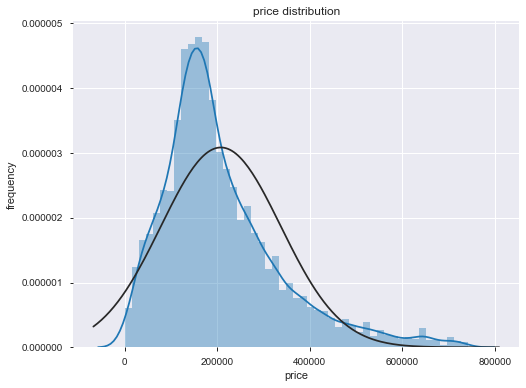

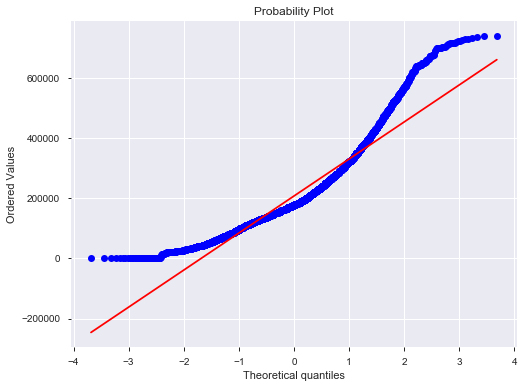

Skewness: 1.3054851659801978
Kurtosis: 2.0305758105025213


In [92]:
fig = plt.figure(figsize=(8, 6))
sns.distplot(df['price'], fit=norm)
plt.ylabel('frequency')
plt.title('price distribution')

fig = plt.figure(figsize=(8, 6))
stats.probplot(df['price'], plot = plt)
plt.show()

print("Skewness: " + str(df["price"].skew()))
print("Kurtosis: " + str(df["price"].kurt()))

From the above analysis, we can conclude that the houses prices are skewed. In linear model, one assumption is that training sample has the similar distribution with the real data. Also, normalizing data usually benefits the performance of the model. We decided to normalize the price data first. We applied `log transformation` to the price by adding a constant `88000` and then using `np.log1p` and stored the data in a new column named `price_t`

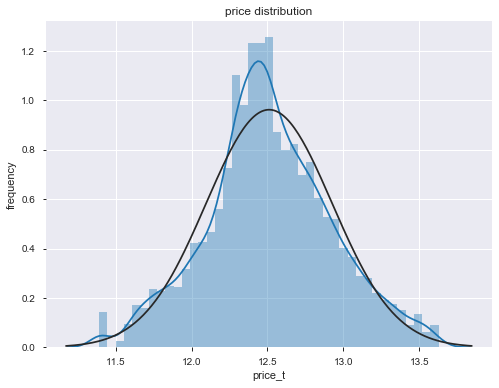

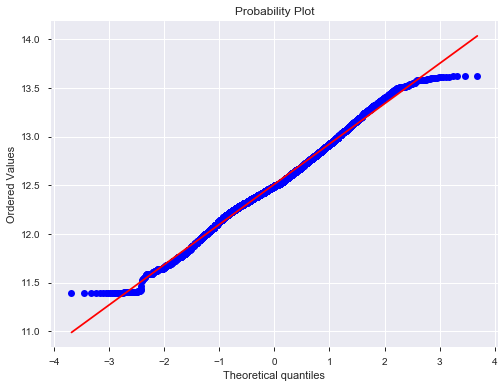

Skewness: 0.05637766761117498
Kurtosis: 0.05489061107458548


In [93]:
df['price_t'] = np.log1p(df["price"] + 88000)
fig = plt.figure(figsize=(8, 6))
sns.distplot(df['price_t'],fit=norm)
plt.ylabel('frequency')
plt.title('price distribution')

fig = plt.figure(figsize=(8, 6))
stats.probplot(df["price_t"], plot=plt)
plt.show()

print("Skewness: " + str(df["price_t"].skew()))
print("Kurtosis: " + str(df["price_t"].kurt()))

Then we will examine other features' skewness. We only focus on the columns whose `dtype` is float or int and has not been normalized before. 

In [94]:
feature_examination = ["lot_size", "restaurant_count", 'area', 'arts_count', 'walk',
                       'grocery_count', 'number_baths', 'number_beds',
                       'restaurant_rating', 'restaurant_price', 'transit' ]
feature_skewness = {}
for i in feature_examination:
    feature_skewness[i] = skew(df[i])
s = pd.DataFrame.from_dict(feature_skewness, orient='index')
s

,0
lot_size,6.970161
restaurant_count,3.209055
area,1.842486
arts_count,1.707064
walk,0.176959
grocery_count,1.669556
number_baths,1.364899
number_beds,0.204227
restaurant_rating,-2.458642
restaurant_price,-1.340235


Above are the features with their skewnesses. We then used `Box Cox Transformation` to normalize them. We chose features whose skewness larger than 1 or less than -1. We used the `lambda` that maximizes the `log-likelihood` for the function. Since some features contain 0, we can not use the default method to choose lambda. We set lambda to be 0.15 according to another [house price prediction project](https://brianmusisi.com/design/Predicting+House+Prices-2.html).

In [97]:
s_1 = s[(s[0] > 1 )]
res = list(s_1.index)
new = []
df = df[df['area'] > 0]
for i in res:
    new_column = i + "_t"
    new.append(new_column)
    df[new_column] = boxcox1p(df[i], 0.1)
s_n1 = s[(s[0] < -1 )]
res_n = list(s_n1.index)
for i in res_n:
    new_column = i + "_t"
    new.append(new_column)
    df[new_column] = boxcox1p(df[i], 3)

In [98]:
feature_skewness_new = {}
for i in new:
    feature_skewness_new[i] = skew(df[i])
s_new = pd.DataFrame.from_dict(feature_skewness_new, orient='index')
s_new

,0
lot_size_t,0.356158
restaurant_count_t,-0.063057
area_t,0.455719
arts_count_t,0.770425
grocery_count_t,0.281307
number_baths_t,0.923894
restaurant_rating_t,-0.631014
restaurant_price_t,0.516517


The `Box Cox Transformation` makes the features more normalized.

#### Training and Testing Dataset

The last thing we need to do is to split our dataset into training and testing dataset. In this project, we will use 30% of the data to be our testing dataset and 70% of them to be used for trainging.

In [99]:
train, test = train_test_split(df, test_size=0.3)

## Model

We will use the training dataset that we generated above for training model. We chose several popular models that we found in the previous house price prediction projects. We built each of them and used ensemble method to generate a better prediction outcome. 


Lasso
Random Forest
ada boost
SVR
Linear Regression
KNN
Enet

LightGBM
Lasso
RandomForest
https://www.kaggle.com/flennerhag/ml-ensemble-scikit-learn-style-ensemble-learning#4.-Ensemble-learning

The model in this project is based on the idea of esembling. 

In [101]:
drop_list = ["price","lot_size", "restaurant_count", "area","arts_count",
             "grocery_count", "number_baths","restaurant_rating",
             "restaurant_price"]
df_model = df.drop(drop_list, axis = 1)




In [102]:
from sklearn.preprocessing import LabelEncoder
numerics = ['int64', 'float64']
df_num = df_model.select_dtypes(include = numerics)
df_cat = df_model.select_dtypes(include = "object")

df_process = pd.DataFrame()

# For each categorical column
# We fit a label encoder, transform our column and 
# add it to our new dataframe
label_encoders = {}
for col in df_cat.columns:
    print("Encoding " + col)
    new_label = LabelEncoder()
    df_process[col] = new_label.fit_transform(df_model[col])
    label_encoders[col] = new_label

df_model_label = pd.concat([df_num, df_process], axis = 1)
df_model_label.info()

Encoding dishwasher
Encoding microwave
Encoding washer
Encoding dryer
Encoding refrigerator
Encoding building_type
Encoding heating_system
Encoding cooling_system
Encoding parking
Encoding stories
Encoding postcode
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6044 entries, 0 to 6043
Data columns (total 26 columns):
number_beds            6044 non-null int64
built_year             6044 non-null int64
latitude               6044 non-null float64
longitude              6044 non-null float64
walk                   6044 non-null float64
transit                6044 non-null int64
price_t                6044 non-null float64
lot_size_t             6044 non-null float64
restaurant_count_t     6044 non-null float64
area_t                 6044 non-null float64
arts_count_t           6044 non-null float64
grocery_count_t        6044 non-null float64
number_baths_t         6044 non-null float64
restaurant_rating_t    6044 non-null float64
restaurant_price_t     6044 non-null float64
dishwashe

In [103]:
df_model_label 

,number_beds,built_year,latitude,longitude,walk,transit,price_t,lot_size_t,restaurant_count_t,area_t,...,microwave,washer,dryer,refrigerator,building_type,heating_system,cooling_system,parking,stories,postcode
0,3,2008,40.381554,-80.011000,76.0,69,12.629708,13.284717,3.195079,11.109463,...,1,0,0,1,3,3,0,0,1,25
1,3,1950,40.367800,-80.075030,13.0,27,12.563751,14.855876,1.161232,10.374939,...,0,0,0,0,2,8,0,0,1,38
2,3,1920,40.504215,-80.047740,21.0,34,12.495008,13.437198,3.622044,11.051071,...,0,1,1,1,2,8,6,23,1,1
3,3,1940,40.362812,-79.978810,57.0,42,12.061053,14.718583,4.097307,10.744771,...,0,0,0,0,2,8,9,0,0,26
4,3,1950,40.380720,-79.969870,76.0,69,12.295003,13.095013,3.682731,10.617640,...,0,0,0,0,2,8,0,0,5,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6039,3,1955,40.319862,-80.083725,18.0,0,12.931205,17.206192,2.148140,10.741958,...,0,0,0,0,2,8,0,0,0,37
6040,3,1900,40.500248,-80.060110,75.0,40,12.421188,13.875101,4.269436,11.016325,...,0,0,0,0,2,8,0,27,1,1
6041,3,1950,40.492554,-79.890110,14.0,35,13.021440,15.110311,3.492828,11.240314,...,1,1,1,1,2,3,0,0,1,14
6042,3,1972,40.451103,-79.709590,27.0,21,12.581082,14.732480,3.020055,10.983590,...,1,1,1,1,2,3,0,0,0,36


In [72]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

ValueError: could not convert string to float: 'Asphalt'

## Reference

1. Pittsburgh property sold list, [link](https://www.trulia.com/sold/Pittsburgh,PA/).
2. Introduction to Ensembling/Stacking in Python, [link](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook).
3. ML-Ensemble: Scikit-learn style ensemble learning, [link](https://www.kaggle.com/flennerhag/ml-ensemble-scikit-learn-style-ensemble-learning#4.-Ensemble-learning)